## Problem statement:
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

## Step 1 : Importing Packages

In [3]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import shutil
import sys

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Step 2 : Importing Skin Cancer Data and Understanding Data

- Number of Images
- Classes

Data has been downloaded and stored in a folder 'Images' and divided into 'Train' and 'Test' folder.

Dataset contains 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [10]:
# Defining the path for train and test images

data_dir_train = pathlib.Path("/content/drive/MyDrive/CNN_Assignment/Images/Train")
data_dir_test = pathlib.Path('/content/drive/MyDrive/CNN_Assignment/Images/Test')

In [3]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Number of Images in Training Set:",image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Number of Images in Testing Set:",image_count_test)

Number of Images in Training Set: 2239
Number of Images in Testing Set: 118


## Step 3 : Data Input and Preprocessing

### Creating the Datasets

We will use 80% of the images for training, and 20% for validation.


In [6]:
batch_size = 32
img_height = 180
img_width = 180

In [12]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [13]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [14]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualizing the Data

- Visualize one instance of all the nine classes present in the dataset

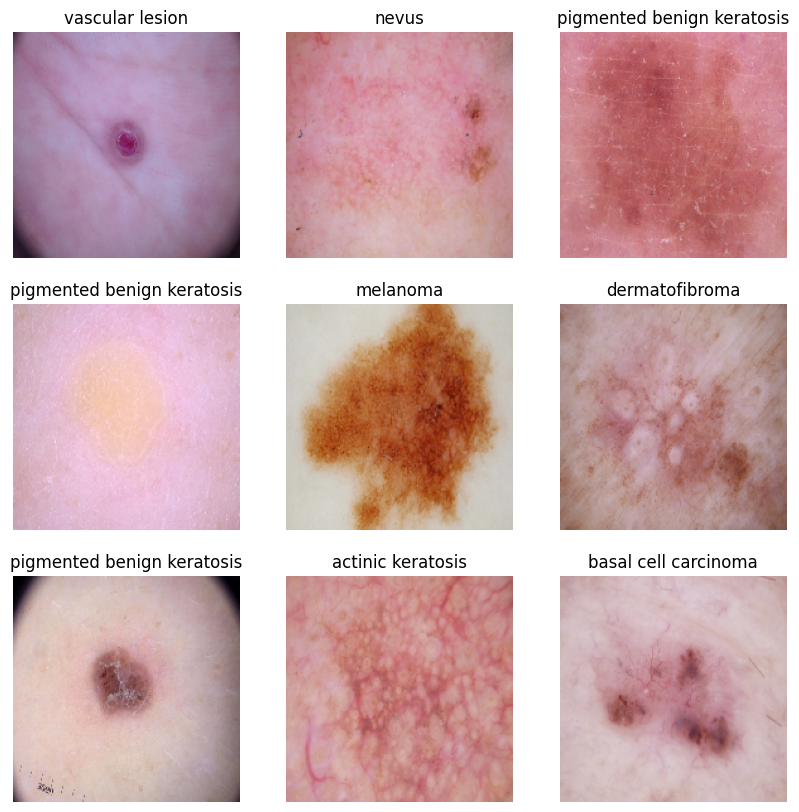

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


### Configure the dataset for performance

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

Let's make sure to use buffered prefetching so we can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Step 4: Modelling

- Model_1: Basic CNN Model
- Model_2: Basic CNN Model with Dropout Layer and Data Augmentation to fix overfitting
- Model_3: Basic CNN Model with Dropout Layer and Data Augmentation to fix overfitting along with rebalanced class dataset

### Model 1: Basic CNN Model

In [ ]:
## Basic CNN Model
## Rescaling to normalize pixel values between (0,1).
## Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1).
## The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]


num_classes = 9

model_1 = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)), # standardize values to be in the [0, 1]
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### Optimizer and Loss Function

We will use Adam optimization which is a stochastic gradient descent method, based on adaptive estimation of first-order and second-order moments which is memory efficient and computationally less intensive


Sparse Cross Entropy calculates the cross entropy loss between the labels and predictions.

We use this crossentropy loss function when there are two or more label classes.

In [ ]:


learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

model_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [ ]:
# View the summary of all layers
model_1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,997,481 (15.25 MB)

 Trainable params: 3,997,481 (15.25 MB)

 Non-trainable params: 0 (0.00 B)

### Train the Model

In [ ]:
epochs = 30
history = model_1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[learn_control]
)

Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.2090 - loss: 2.0847 - val_accuracy: 0.2685 - val_loss: 1.9211 - learning_rate: 0.0010
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.3625 - loss: 1.7783 - val_accuracy: 0.4787 - val_loss: 1.5695 - learning_rate: 0.0010
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.4916 - loss: 1.4830 - val_accuracy: 0.4966 - val_loss: 1.5302 - learning_rate: 0.0010
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5121 - loss: 1.3705 - val_accuracy: 0.5190 - val_loss: 1.4208 - learning_rate: 0.0010
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5442 - loss: 1.3276 - val_accuracy: 0.4922 - val_loss: 1.4729 - learning_rate: 0.0010
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5292 - loss: 1.3218 - val_accuracy: 0.5324 - val_loss: 1.3822 - learning_rate: 0.0010
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5852 - loss: 1.1845 - val_acc

### Visualizing training results

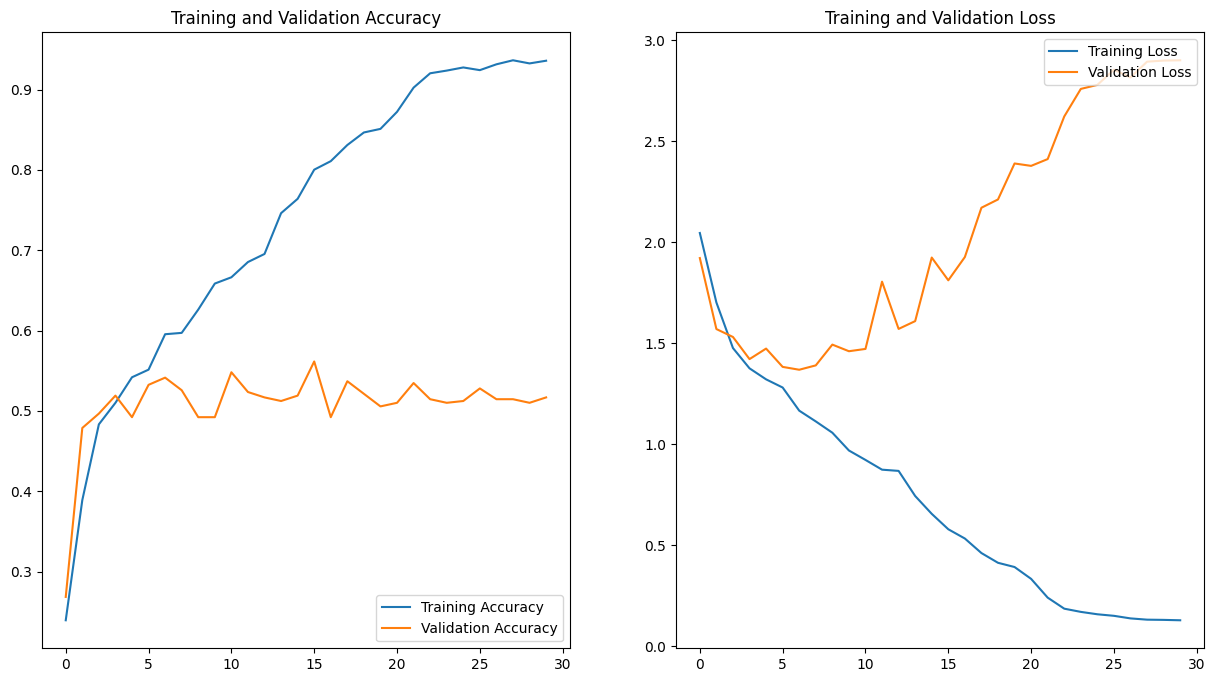

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Observations


1. The training accuracy and validation accuracy are off by large margin and the model has only achieved around 51% accuracy on the validation set.
2. The training loss is very low, but validation loss is high and fluctuating.




Let's look at what went wrong and try to increase the overall performance of the model.


### **Overfitting**

In the above plots, the training accuracy is increasing linearly,  whereas validation accuracy is around 51% in the training process. Also, the difference in accuracy between training and validation accuracy is a sign of overfitting.


There are multiple ways to fight overfitting in the training process. we'll use data augmentation and add dropout to our model.

### Data augmentation

Overfitting occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield  images which helps model to look better at more generalised dataset.

In [16]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# augumentation strategy with flip,rotate,skew,shift, zoom, brightness, contrast, saturation, hue
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
    input_shape=(img_height,
                img_width,
                3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

### Visualize how your augmentation strategy works for one instance of training image.

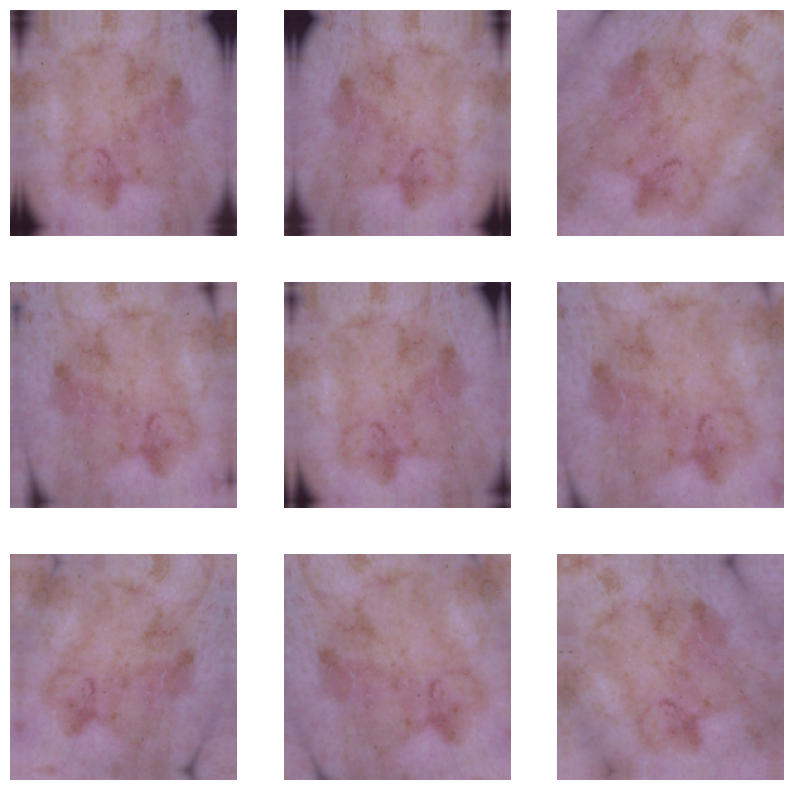

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Dropout

Another technique to reduce overfitting is to introduce Dropout to the network, which helps with regularization.

In a Dropout step to a layer it randomly drops out output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. which tells how much percent to dropout

We will create model_2 using the base model_1 and use layers.Dropout  to add dropout step and train with augmented images.

### Model_2 : Basic CNN Model with Dropout Layer and Data Augmentation to fix overfitting


In [ ]:
# Basic CNN Model with Dropout Layer and Data Augmentation to fix overfitting

num_classes = 9

model_2 = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
### Todo, choose an appropirate optimiser and loss function

learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)


model_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model_2.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_9 (Rescaling)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Training Model


In [ ]:
epochs = 30
history = model_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[learn_control]
)

Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.1960 - loss: 2.1170 - val_accuracy: 0.3289 - val_loss: 1.9005 - learning_rate: 0.0010
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.3280 - loss: 1.8216 - val_accuracy: 0.4139 - val_loss: 1.6398 - learning_rate: 0.0010
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.4059 - loss: 1.6232 - val_accuracy: 0.5123 - val_loss: 1.4161 - learning_rate: 0.0010
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.4992 - loss: 1.4048 - val_accuracy: 0.5257 - val_loss: 1.3744 - learning_rate: 0.0010
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5186 - loss: 1.3835 - val_accuracy: 0.5324 - val_loss: 1.3453 - learning_rate: 0.0010
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5244 - loss: 1.3109 - val_accuracy: 0.5056 - val_loss: 1.4012 - learning_rate: 0.0010
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.5236 - loss: 1.3356 - val_acc

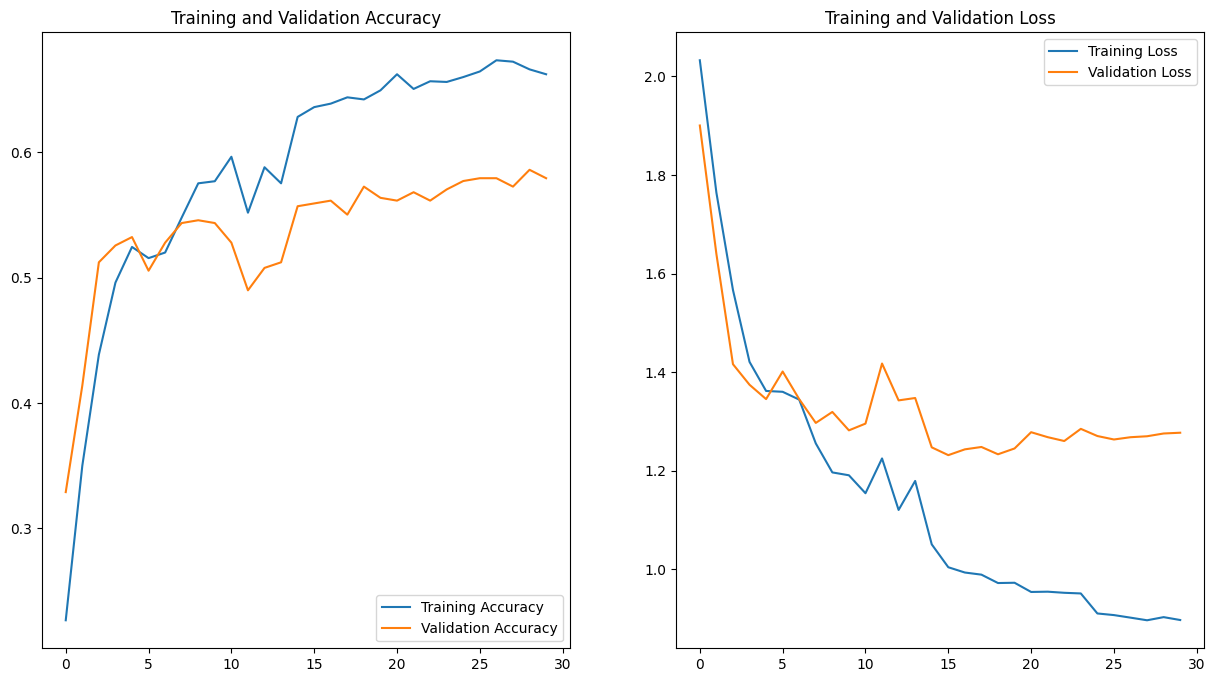

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Observation -

From above plot we can see that the overfitting is resolved as training accuracy and validation accuracy are not far away from each other buth the model is underfitting as the accuracy is around 58% which is very low

Lets observe see how we can increase accuracy by having a closer look at the dataset

#### Distribution of Classes in the Training Dataset.

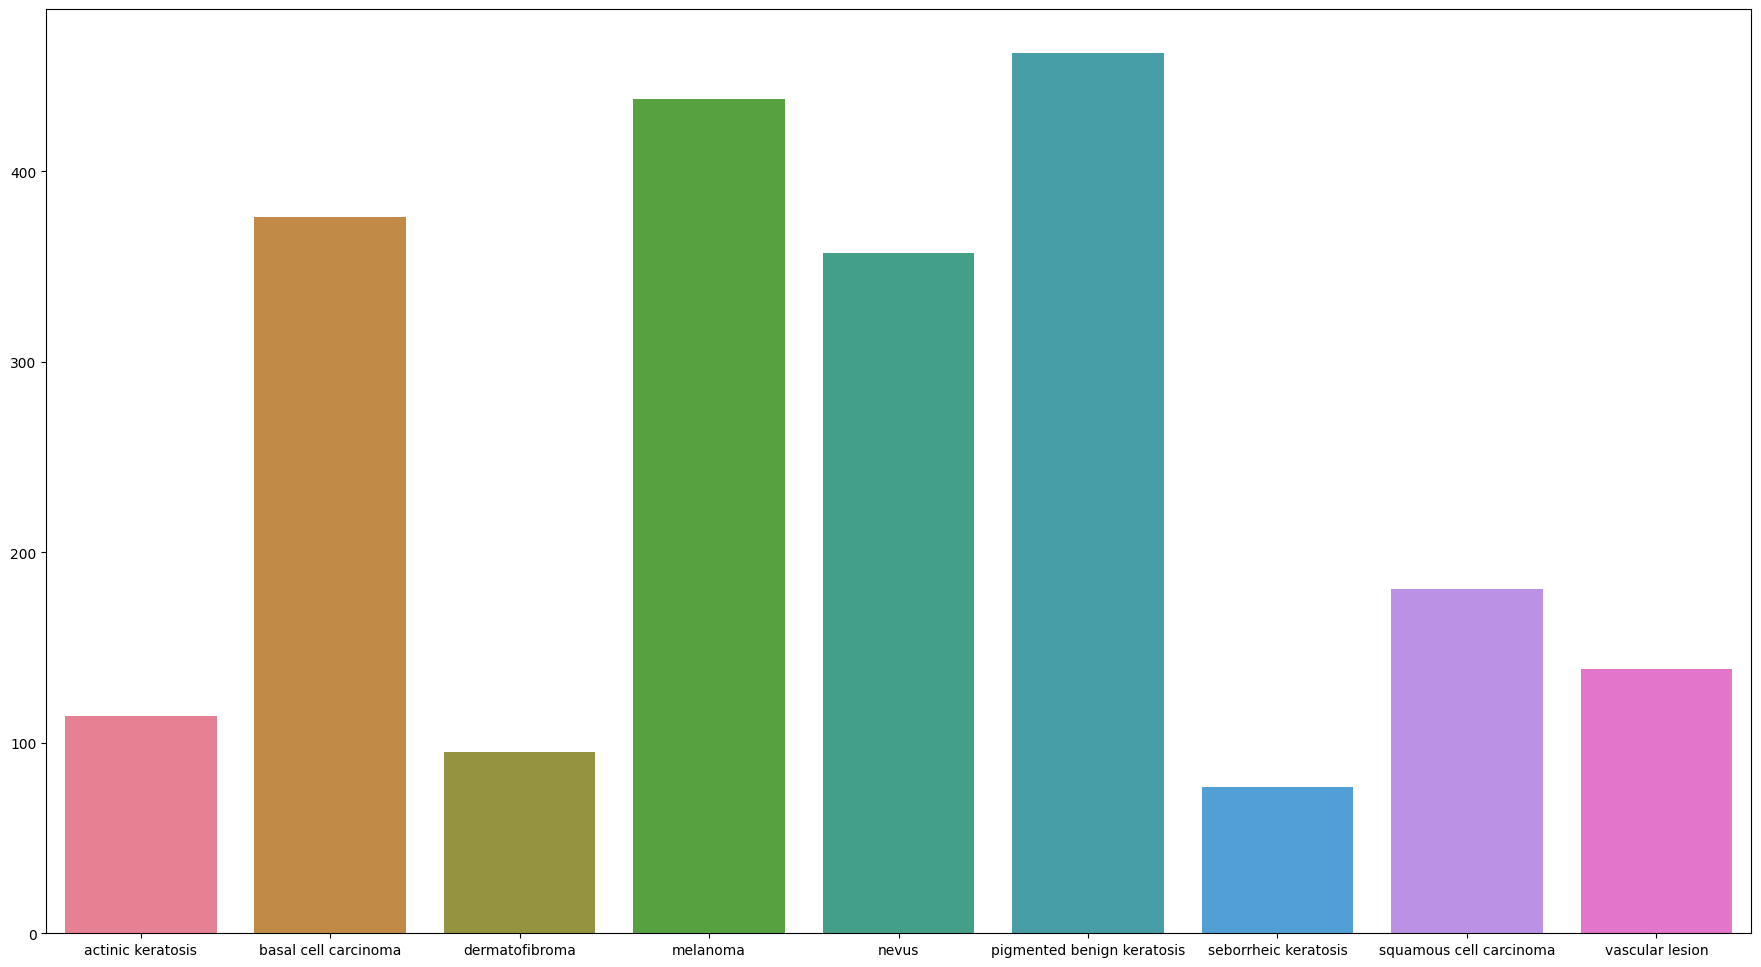

In [ ]:
path_to_training_dataset = os.path.abspath(data_dir_train) + "/"

class_dict_orig = {}
for i in class_names:
    class_path = pathlib.Path(path_to_training_dataset + i)
    class_count = len(list(class_path.glob('*.jpg')))
    class_dict_orig[i] = class_count

import seaborn as sns
fig, ax = plt.subplots(figsize=(22,12))
sns.barplot(x=list(class_dict_orig.keys()), y=list(class_dict_orig.values()),palette="husl",hue=list(class_dict_orig.keys()))
plt.show()

In [ ]:
pd.DataFrame(list(class_dict_orig.items()),columns = ["Class Names","Number of Images"]).sort_values(by=["Number of Images"])

,Class Names,Number of Images
6,seborrheic keratosis,77
2,dermatofibroma,95
0,actinic keratosis,114
8,vascular lesion,139
7,squamous cell carcinoma,181
4,nevus,357
1,basal cell carcinoma,376
3,melanoma,438
5,pigmented benign keratosis,462


### Class Imbalance

<br>

**Class with lowest Data is "seborrheic keratosis" with 77 images**

**Class with Highest Data is "pigmented benign keratosis" with 462 Images**


To fix the class imbalance issue, we can make minor changes to the exisitng dataset like flips, rotations and generate new data which will be new images for our CNN model.

The rational here is that our CNN model should be able to classify images in different orientations and perform better in real world conditions and should be invariant.

### Rectify the Class Imbalance

#### Augmentor - Data Augmentation Package

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install Augmentor

In [ ]:

import Augmentor
train_base_dir = path_to_training_dataset.split('Train')[0]
new_train_dir = train_base_dir + "Train_class_balanced/"
shutil.copytree(path_to_training_dataset,new_train_dir)
for i in class_names:
    print(path_to_training_dataset + i)
    p = Augmentor.Pipeline(path_to_training_dataset + i, new_train_dir+i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

/content/drive/MyDrive/CNN_Assignment/Images/Train/actinic keratosis
Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_Assignment/Images/Train_class_balanced/actinic keratosis.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EC5A80EB730>: 100%|██████████| 500/500 [00:18<00:00, 26.81 Samples/s]


/content/drive/MyDrive/CNN_Assignment/Images/Train/basal cell carcinoma
Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_Assignment/Images/Train_class_balanced/basal cell carcinoma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EC632082170>: 100%|██████████| 500/500 [00:25<00:00, 19.98 Samples/s]


/content/drive/MyDrive/CNN_Assignment/Images/Train/dermatofibroma
Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_Assignment/Images/Train_class_balanced/dermatofibroma.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7EC5BA106BF0>: 100%|██████████| 500/500 [00:23<00:00, 21.65 Samples/s]


/content/drive/MyDrive/CNN_Assignment/Images/Train/melanoma
Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_Assignment/Images/Train_class_balanced/melanoma.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7EC5A8112800>: 100%|██████████| 500/500 [01:31<00:00,  5.44 Samples/s]


/content/drive/MyDrive/CNN_Assignment/Images/Train/nevus
Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_Assignment/Images/Train_class_balanced/nevus.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7EC5A81637F0>: 100%|██████████| 500/500 [01:10<00:00,  7.07 Samples/s]


/content/drive/MyDrive/CNN_Assignment/Images/Train/pigmented benign keratosis
Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_Assignment/Images/Train_class_balanced/pigmented benign keratosis.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EC5A8173E50>: 100%|██████████| 500/500 [00:18<00:00, 26.56 Samples/s]


/content/drive/MyDrive/CNN_Assignment/Images/Train/seborrheic keratosis
Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_Assignment/Images/Train_class_balanced/seborrheic keratosis.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7EC5A81EB580>: 100%|██████████| 500/500 [00:41<00:00, 12.00 Samples/s]


/content/drive/MyDrive/CNN_Assignment/Images/Train/squamous cell carcinoma
Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_Assignment/Images/Train_class_balanced/squamous cell carcinoma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EC5BA13B310>: 100%|██████████| 500/500 [00:18<00:00, 27.19 Samples/s]


/content/drive/MyDrive/CNN_Assignment/Images/Train/vascular lesion
Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_Assignment/Images/Train_class_balanced/vascular lesion.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EC5D2125F30>: 100%|██████████| 500/500 [00:18<00:00, 26.43 Samples/s]


### Lets observe the distribution of augmented data after adding new images to the original training data.

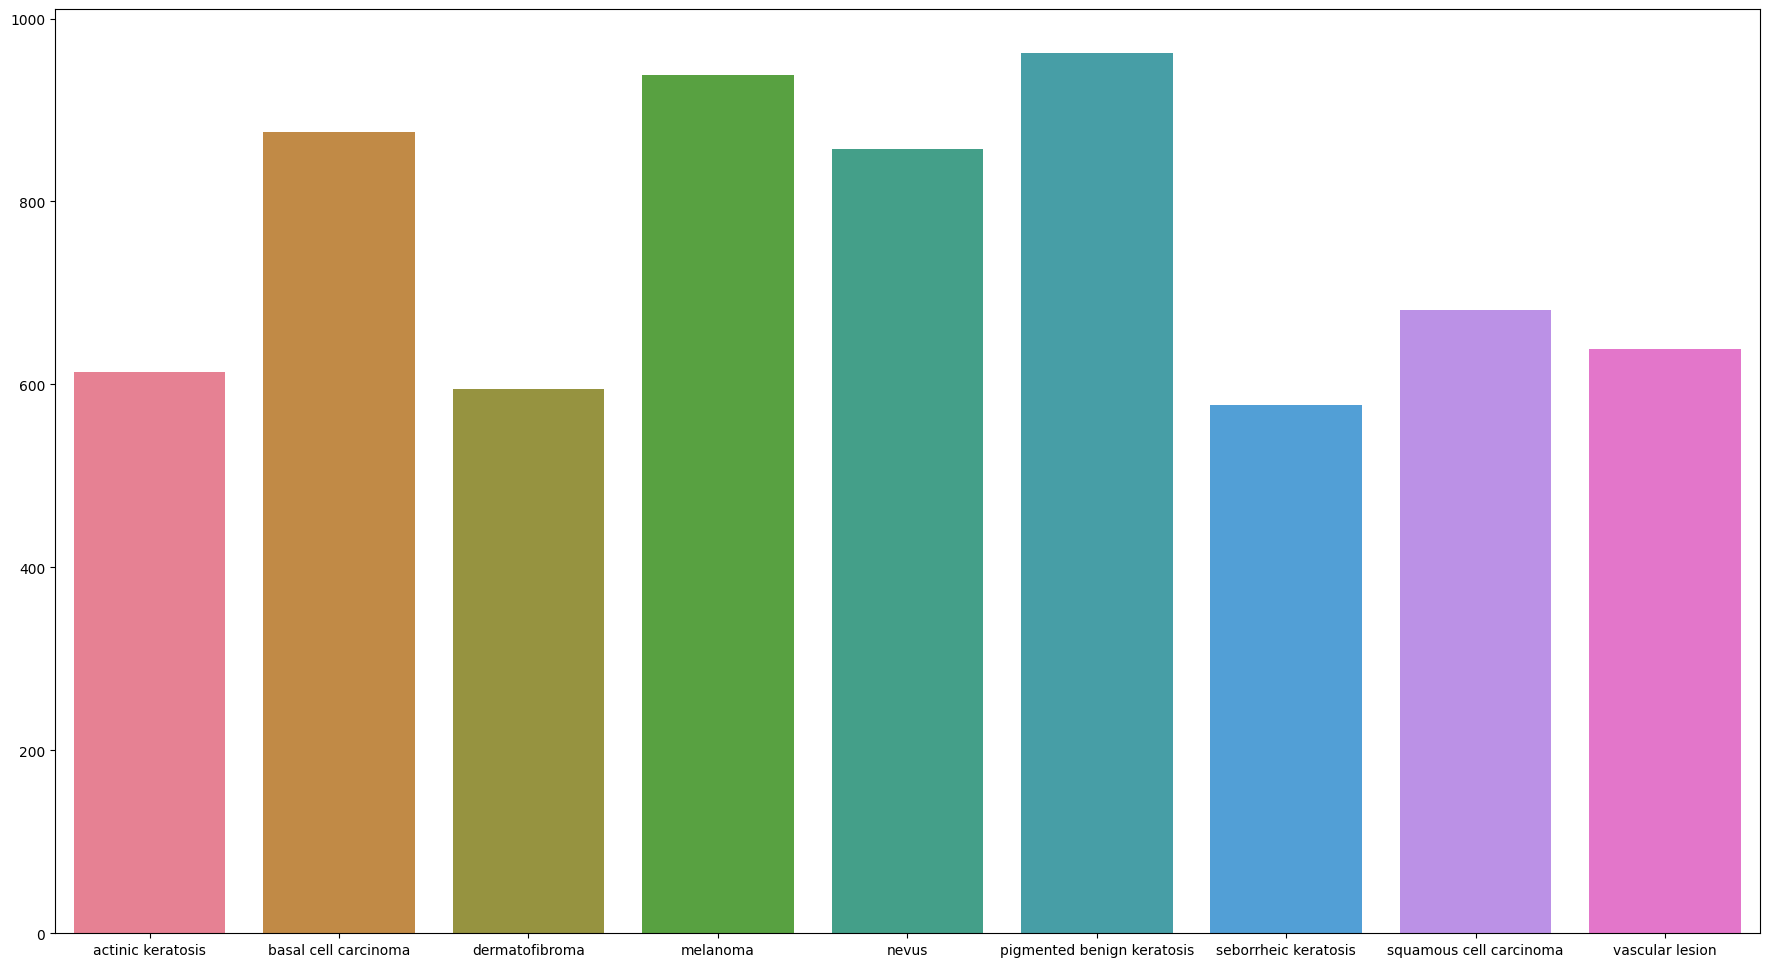

In [ ]:
class_dict_new = {}
for i in class_names:
    class_path = pathlib.Path(new_train_dir + i)
    class_count = len(list(class_path.glob('*.jpg')))
    class_dict_new[i] = class_count

import seaborn as sns
fig, ax = plt.subplots(figsize=(22,12))
sns.barplot(x=list(class_dict_new.keys()), y=list(class_dict_new.values()),palette="husl",hue=list(class_dict_new.keys()))
plt.show()

In [ ]:
pd.DataFrame(list(class_dict_new.items()),columns = ["Class Names","Number of Images"]).sort_values(by=["Number of Images"])

,Class Names,Number of Images
6,seborrheic keratosis,577
2,dermatofibroma,595
0,actinic keratosis,614
8,vascular lesion,639
7,squamous cell carcinoma,681
4,nevus,857
1,basal cell carcinoma,876
3,melanoma,938
5,pigmented benign keratosis,962


#### Observations -

- All the classes now have 500 images minimum and the class imbalance is fixed.

### Model_3: Basic CNN Model with Dropout Layer and Data Augmentation to fix overfitting along with rebalanced class dataset and Batch Normalization

- We will use the new augmented data along with original data to train the model and increase epoch to 50.
- We can add learning control which will help to reduce the learning rate incase the model validation accuracy is not increasing.
- We are also adding a Batch Normalization step.

In [19]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  new_train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [20]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  new_train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [22]:
# Model_3: Basic CNN Model with Dropout Layer and Data Augmentation to fix overfitting along with rebalanced class dataset and Normalization
num_classes = 9

model_3 = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.BatchNormalization(),
  layers.Dense(num_classes)
])

learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

model_3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


epochs = 50
history = model_3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[learn_control]
)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 656s 4s/step - accuracy: 0.3640 - loss: 1.8089 - val_accuracy: 0.1084 - val_loss: 5.0984 - learning_rate: 0.0010
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 70s 236ms/step - accuracy: 0.5059 - loss: 1.3175 - val_accuracy: 0.2524 - val_loss: 2.1339 - learning_rate: 0.0010
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 237ms/step - accuracy: 0.5664 - loss: 1.1677 - val_accuracy: 0.2843 - val_loss: 1.9465 - learning_rate: 0.0010
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 45s 258ms/step - accuracy: 0.5925 - loss: 1.0724 - val_accuracy: 0.5880 - val_loss: 1.1879 - learning_rate: 0.0010
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 79s 242ms/step - accuracy: 0.6382 - loss: 0.9695 - val_accuracy: 0.2814 - val_loss: 3.2610 - learning_rate: 0.0010
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 40s 239ms/step - accuracy: 0.6238 - loss: 1.0161 - val_accuracy: 0.5739 - val_loss: 1.2045 - learning_rate: 0.0010
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 43s 248ms/step - accuracy: 0.684

In [ ]:
# View the summary of all layers
model_3.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_8 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,992,445 (45.75 MB)

 Trainable params: 3,997,481 (15.25 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,994,964 (30.50 MB)

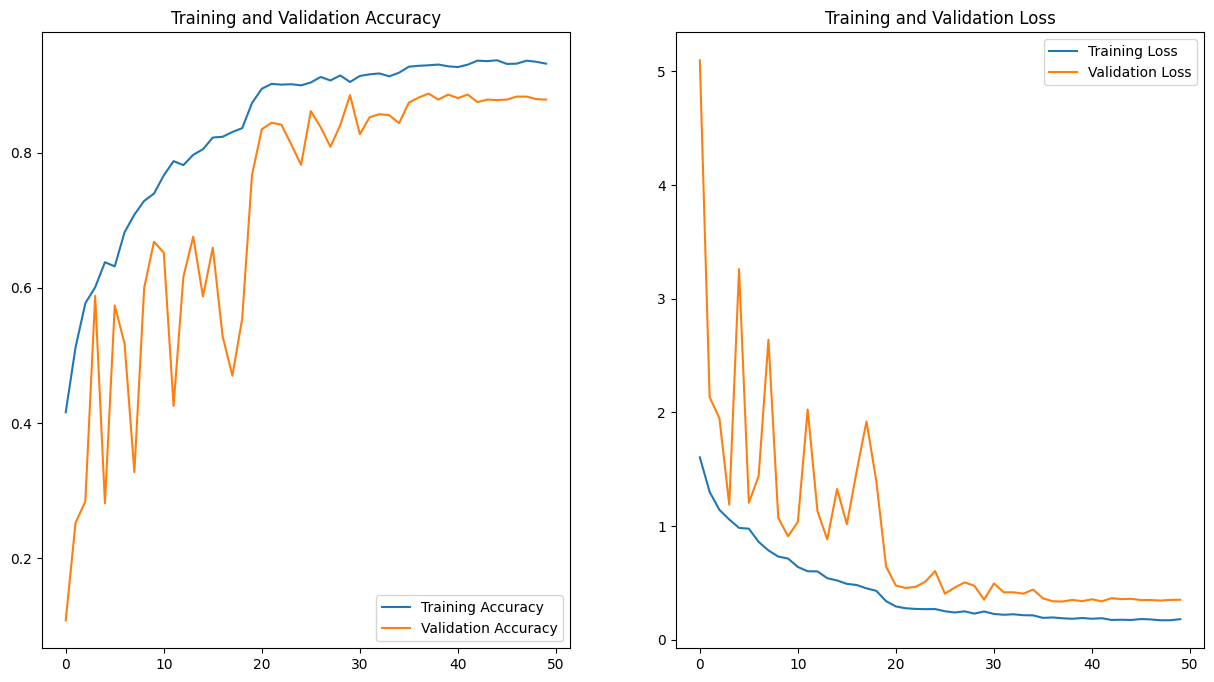

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### **Saving the Final Model**

In [26]:
from keras.models import load_model

MODEL_PATH = '/content/drive/MyDrive/CNN_Assignment/final_model_3.keras'


In [ ]:
# Now save model in drive
model_3.save(MODEL_PATH)

In [38]:
# Load Model
final_model = load_model(MODEL_PATH)

In [39]:
final_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 180, 180, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 90, 90, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 45, 45, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,993,853 (45.75 MB)

 Trainable params: 3,997,833 (15.25 MB)

 Non-trainable params: 352 (1.38 KB)

 Optimizer params: 7,995,668 (30.50 MB)

### Observation -
- We can see that the underfitting is resolved and the validation accuracy is 88% which is close to 93% accuracy which suggests it is a more generalised model.



### **Testing the model**

In [29]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
data_dir_test,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [40]:
final_model.evaluate(test_ds)

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.4239 - loss: 2.9838


[2.9604732990264893, 0.43220338225364685]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Actual Class: basal cell carcinoma
Predictive Class: basal cell carcinoma


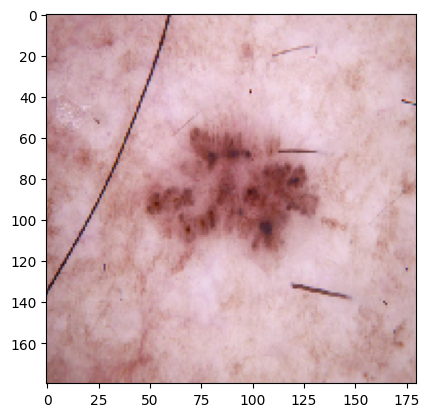

In [41]:
from glob import glob
from tensorflow.keras.preprocessing.image import load_img, img_to_array
test_image_path = os.path.join(data_dir_test, class_names[1], '*')
test_image = glob(test_image_path)
test_image_rescale = load_img(test_image[5],target_size=(180,180,3))
plt.imshow(test_image_rescale)
plt.grid(False)

image = np.expand_dims(test_image_rescale,axis=0)
pred = final_model.predict(image)
pred = np.argmax(pred)
pred_class = class_names[pred]
print(f"Actual Class: {class_names[1]}" + '\n' + "Predictive Class: " + pred_class)

## Step 5 : Conclusion


* **Model_1: Basic CNN Model**
  * Basic CNN Model without dropout layers and no augmentation
  * Model was **overfitting** and had training accuracy of 93% and **validation accuracy of 51%**.

* **Model_2: Basic CNN Model with Dropout Layer and Data Augmentation to fix overfitting**
  * Model 2 addition of dropout layers and data augmentation helped reduce overfitting but the **accuracy was very low at 58%** suggesting that the model is **underfitting**
  * **Class Imbalance** was one of the causes for underfitting.

* **Model_3: Basic CNN Model with Dropout Layer and Data Augmentation to fix overfitting along with rebalanced class dataset and Batch Normalization**
  * Using Augmentor 500 images were added for each class to training dataset.
  * Accuracy of model improved with no signs of underfitting and overfitting.
  * Normalization further helped with increasing the accuracy
  * **Training accuracy of 93% and Validation Accuracy of 88% is observed.**
  
